## Preprocess and validate eADAGE network data

eADAGE G-G network/edge list was generated by Alex using the script at `../generic_expression_patterns_modules/make_GiG_network.R`. 

Here, we preprocess it to reweight negative edges, add generic gene info from `../pseudomonas_analysis/annot_df.tsv`, and save in a file that can be quickly loaded by `graph-tool` for subsequent analyses.

In [1]:
import os

import numpy as np
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# relevant file paths
data_dir = './data'
unprocessed_edge_list = os.path.join(data_dir, 'edgeList.csv')

# map of Pa gene names to generic/not generic status, generated by Alex
generic_gene_map = os.path.join('..', 'pseudomonas_analysis', 'annot_df.tsv')

# save edge list with preprocessed weight information
processed_edge_list = os.path.join(data_dir, 'edge_list_processed_unsigned.csv')

# place to save preprocessed graph/attributes, in graph-tool binary format
processed_graph = os.path.join(data_dir, 'eadage_generic_graph_unsigned.gt')

#### Load edge list and handle negative edge weights

Most algorithms for community detection and betweenness don't work with negative weights/correlations. Taking inspiration from WGCNA, we can solve this problem in one of two ways:
* Unsigned: `weight = abs(corr(g1, g2))`
* Signed: `weight = abs((1 + corr(g1, g2) / 2)`
 
We should probably try both eventually, but for now we'll just use the unsigned version (taking absolute value of negative edges). I tend to agree with the rationale in this BioStars post for taking absolute values (unsigned) rather than rescaling (signed approach): https://www.biostars.org/p/144078/#144088

In [3]:
if not os.path.isfile(processed_edge_list):
    edgelist_df = pd.read_csv(unprocessed_edge_list, index_col=0)
    # take absolute value of edge weights
    edgelist_df['weight'] = edgelist_df.weight.abs()
    edgelist_df.to_csv(processed_edge_list, columns=['from', 'to', 'weight'], index=False)

edgelist_df = pd.read_csv(processed_edge_list)
edgelist_df.head()

,from,to,weight
0,PA0001,PA0002,0.578872
1,PA0001,PA0548,0.510323
2,PA0001,PA0963,0.561494
3,PA0001,PA3637,0.512365
4,PA0001,PA5554,0.554768


In [4]:
annot_df = pd.read_csv(generic_gene_map, sep='\t', index_col=0)
annot_df.head()

,label
PA0001,0
PA0002,0
PA0003,0
PA0004,0
PA0005,0


In [5]:
G = gt.load_graph_from_csv(processed_edge_list,
                           skip_first=True,
                           directed=False,
                           hashed=True,
                           eprop_names=['weight'],
                           eprop_types=['float'])

In [6]:
# add vertex property for generic genes
vprop_generic = G.new_vertex_property('bool')
for ix, v in enumerate(G.vertices()):
    v_name = G.vp['name'][v]
    v_label = annot_df.loc[v_name, 'label']
    vprop_generic[v] = v_label

G.vertex_properties['is_generic'] = vprop_generic

In [7]:
# make sure vertex/edge properties exist
print(G)
print(list(G.vp.keys()))
print(list(G.ep.keys()))

<Graph object, undirected, with 3477 vertices and 31556 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fcf88979fd0>
['name', 'generic']
['weight']


In [8]:
# make sure names/weights from file were loaded properly
for s, t, w in G.iter_edges([G.ep['weight']]):
    print(G.vp['name'][s], G.vp['name'][t], w)
    if s > 0: break

PA0001 PA0002 0.578871792667748
PA0001 PA0548 0.510322953238081
PA0001 PA0963 0.561494130101994
PA0001 PA3637 0.512364523924246
PA0001 PA5554 0.554767556277657
PA0001 PA5556 0.510077492096518
PA0001 PA5557 0.560133539838743
PA0001 PA5560 0.577121244257997
PA0002 PA0004 0.550410666782419


In [9]:
# save graph with attributes to file
G.save(processed_graph, fmt='gt')

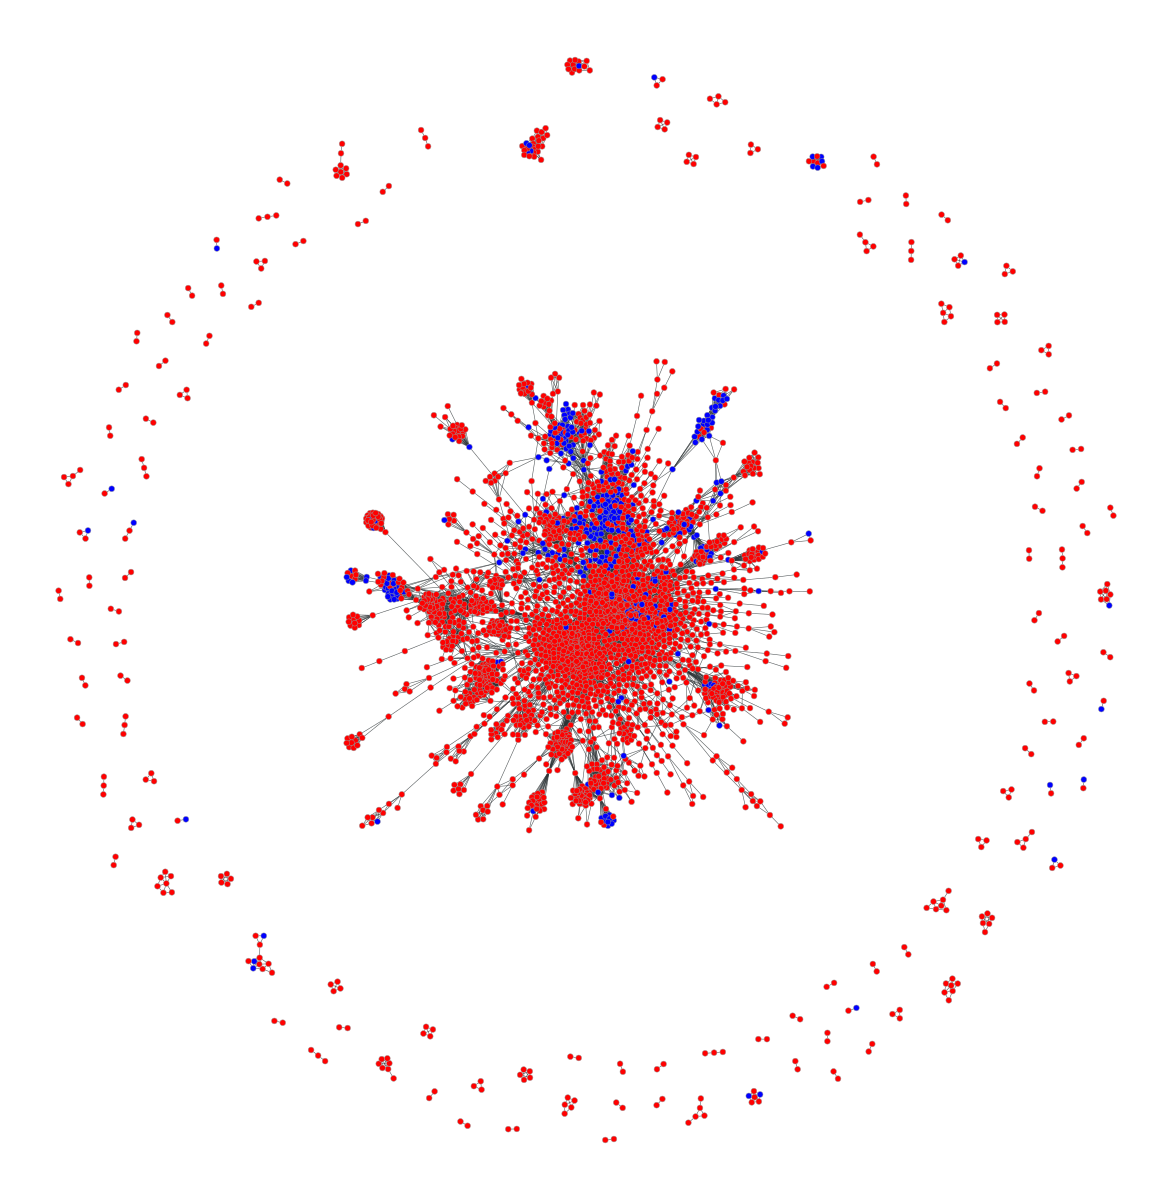

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fcf88979fd0, at 0x7fcf88a61cd0>

In [10]:
# plot generic and non-generic genes, just for fun
# https://stackoverflow.com/a/60462353
red_blue_map = {0: (1, 0, 0, 1), 1: (0, 0, 1, 1)}
plot_color = G.new_vertex_property('vector<double>')
for v in G.vertices():
    plot_color[v] = red_blue_map[G.vp['is_generic'][v]]
gt.graph_draw(G, vertex_fill_color=plot_color)